In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [3]:
image_path="D:/CVR_MINI_PROG/archive (1)/images/images/train"

train_path="D:/CVR_MINI_PROG/archive (1)/images/images/train"
valid_path="D:/CVR_MINI_PROG/archive (1)/images/images/validation"

In [4]:
class_names = [folder for folder in os.listdir(image_path) if os.path.isdir(os.path.join(image_path, folder))]

In [5]:
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [6]:
number_of_images = {}
for class_name in class_names:
    number_of_images[class_name] = len(os.listdir(image_path+"/"+class_name))

images_per_class = pd.DataFrame(list(number_of_images.items()), columns=['Class Name', 'Number of Images'])
images_per_class

,Class Name,Number of Images
0,angry,3993
1,disgust,436
2,fear,4103
3,happy,7164
4,neutral,4982
5,sad,4938
6,surprise,3205


In [7]:
# Training data generator with data augmentation
traindata_generator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator (rescaling only)
validdata_generator = ImageDataGenerator(rescale=1./255)

In [8]:
# Training data
train_generator = traindata_generator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Validation data
validation_generator = validdata_generator.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [9]:
mobilenetV2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [10]:
for layer in mobilenetV2_model.layers:
    layer.trainable = False
    
# Adding custom layers on top of the base model
x = mobilenetV2_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
prediction = Dense(7, activation='softmax')(x)

In [11]:
# Create the final model
model = Model(inputs=mobilenetV2_model.input, outputs=prediction)

In [12]:
# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,100,167 (15.64 MB)

 Trainable params: 1,841,159 (7.02 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

In [14]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [15]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


c:\Users\anshs\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


901/901 ━━━━━━━━━━━━━━━━━━━━ 767s 842ms/step - accuracy: 0.3455 - loss: 1.7818 - val_accuracy: 0.3830 - val_loss: 1.5842 - learning_rate: 0.0010
Epoch 2/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 608s 672ms/step - accuracy: 0.4124 - loss: 1.5355 - val_accuracy: 0.2886 - val_loss: 3.6770 - learning_rate: 0.0010
Epoch 3/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 469s 519ms/step - accuracy: 0.4295 - loss: 1.4907 - val_accuracy: 0.4202 - val_loss: 1.6112 - learning_rate: 0.0010
Epoch 4/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 469s 519ms/step - accuracy: 0.4333 - loss: 1.4726 - val_accuracy: 0.4403 - val_loss: 1.5104 - learning_rate: 0.0010
Epoch 5/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 470s 521ms/step - accuracy: 0.4402 - loss: 1.4558 - val_accuracy: 0.2516 - val_loss: 2.4532 - learning_rate: 0.0010
Epoch 6/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 471s 522ms/step - accuracy: 0.4455 - loss: 1.4378 - val_accuracy: 0.4455 - val_loss: 1.4328 - learning_rate: 0.0010
Epoch 7/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 470s 521ms/step - accuracy: 0.4521 

In [16]:
# Unfreeze the base model and fine-tune
for layer in mobilenetV2_model.layers:
    layer.trainable = True

In [17]:
# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])                            

In [18]:
# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1715s 2s/step - accuracy: 0.2964 - loss: 1.8161 - val_accuracy: 0.4025 - val_loss: 1.6443 - learning_rate: 1.0000e-05
Epoch 2/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1699s 2s/step - accuracy: 0.4235 - loss: 1.4987 - val_accuracy: 0.4215 - val_loss: 1.5111 - learning_rate: 1.0000e-05
Epoch 3/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1696s 2s/step - accuracy: 0.4601 - loss: 1.3961 - val_accuracy: 0.4526 - val_loss: 1.4391 - learning_rate: 1.0000e-05
Epoch 4/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1699s 2s/step - accuracy: 0.4951 - loss: 1.3182 - val_accuracy: 0.4673 - val_loss: 1.4153 - learning_rate: 1.0000e-05
Epoch 5/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1699s 2s/step - accuracy: 0.5252 - loss: 1.2583 - val_accuracy: 0.4895 - val_loss: 1.3439 - learning_rate: 1.0000e-05


In [19]:
# Fine-tune the model
fine_tune_history2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1676s 2s/step - accuracy: 0.4284 - loss: 1.4923 - val_accuracy: 0.4274 - val_loss: 1.4773 - learning_rate: 1.0000e-05
Epoch 2/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1662s 2s/step - accuracy: 0.4744 - loss: 1.3702 - val_accuracy: 0.4612 - val_loss: 1.4109 - learning_rate: 1.0000e-05
Epoch 3/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1663s 2s/step - accuracy: 0.4997 - loss: 1.3067 - val_accuracy: 0.4775 - val_loss: 1.3578 - learning_rate: 1.0000e-05
Epoch 4/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1663s 2s/step - accuracy: 0.5240 - loss: 1.2568 - val_accuracy: 0.5007 - val_loss: 1.2965 - learning_rate: 1.0000e-05
Epoch 5/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1664s 2s/step - accuracy: 0.5421 - loss: 1.2120 - val_accuracy: 0.5330 - val_loss: 1.2434 - learning_rate: 1.0000e-05
Epoch 6/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1665s 2s/step - accuracy: 0.5502 - loss: 1.1797 - val_accuracy: 0.5627 - val_loss: 1.1640 - learning_rate: 1.0000e-05
Epoch 7/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1676s 2s/ste

In [20]:
# Fine-tune the model
fine_tune_history3 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 4630s 5s/step - accuracy: 0.6113 - loss: 1.0406 - val_accuracy: 0.6087 - val_loss: 1.0526 - learning_rate: 1.0000e-05
Epoch 2/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 2804s 3s/step - accuracy: 0.6101 - loss: 1.0313 - val_accuracy: 0.6122 - val_loss: 1.0438 - learning_rate: 1.0000e-05
Epoch 3/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1815s 2s/step - accuracy: 0.6234 - loss: 1.0061 - val_accuracy: 0.6187 - val_loss: 1.0322 - learning_rate: 1.0000e-05
Epoch 4/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1763s 2s/step - accuracy: 0.6267 - loss: 0.9926 - val_accuracy: 0.6203 - val_loss: 1.0271 - learning_rate: 1.0000e-05
Epoch 5/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1750s 2s/step - accuracy: 0.6347 - loss: 0.9731 - val_accuracy: 0.6213 - val_loss: 1.0074 - learning_rate: 1.0000e-05
Epoch 6/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 2767s 3s/step - accuracy: 0.6442 - loss: 0.9540 - val_accuracy: 0.6203 - val_loss: 1.0136 - learning_rate: 1.0000e-05
Epoch 7/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1741s 2s/ste

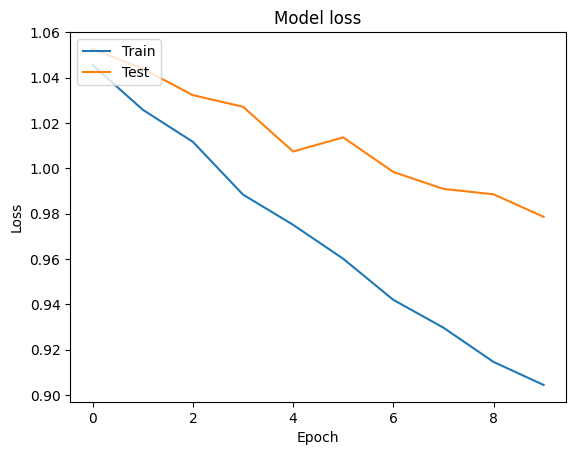

In [21]:
# Plot training & validation loss values
plt.plot(fine_tune_history3.history['loss'])
plt.plot(fine_tune_history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

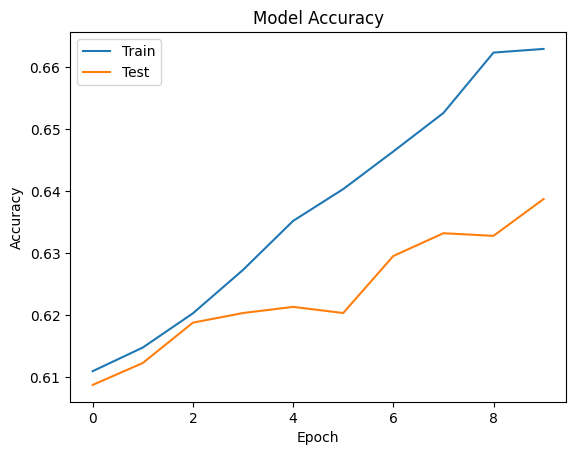

In [22]:
# Plot training & validation loss values
plt.plot(fine_tune_history3.history['accuracy'])
plt.plot(fine_tune_history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
true_classes = validation_generator.classes
predicted_classes = np.argmax(model.predict(validation_generator, steps=int(np.ceil(validation_generator.samples / validation_generator.batch_size))), axis=1)
class_labels = list(validation_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

221/221 ━━━━━━━━━━━━━━━━━━━━ 75s 335ms/step


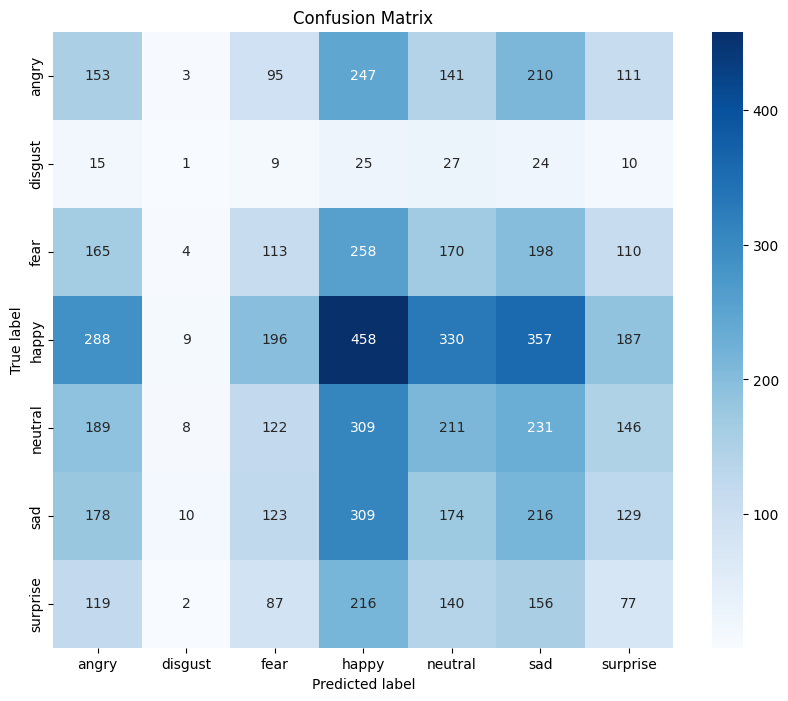

In [24]:
# Plotting confusion matrix with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [25]:
#classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.16      0.15       960
     disgust       0.03      0.01      0.01       111
        fear       0.15      0.11      0.13      1018
       happy       0.25      0.25      0.25      1825
     neutral       0.18      0.17      0.18      1216
         sad       0.16      0.19      0.17      1139
    surprise       0.10      0.10      0.10       797

    accuracy                           0.17      7066
   macro avg       0.14      0.14      0.14      7066
weighted avg       0.17      0.17      0.17      7066



In [26]:
model.save('expressions_emotion_detection_model.h5')

In [27]:
# Convert the model architecture to JSON
model_json = model.to_json()

# Save the model architecture as a JSON file
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

print("Model architecture saved to model_architecture.json")


Model architecture saved to model_architecture.json


In [28]:
import pickle

# Save the entire model using Pickle
with open("model_pickle.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved as a Pickle file: model_pickle.pkl")


Model saved as a Pickle file: model_pickle.pkl
